### Protocluster fraction

Number and fraction of protocluster galaxies over time. Figure 2 from the paper.

In [1]:
import pandas as pd
import numpy as np

from astropy.cosmology import Planck13, z_at_value
import astropy.units as u

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from palettable.tableau import GreenOrange_12
cmap = GreenOrange_12.hex_colors

c = 2.97e8 # m s^-1
h = 0.673

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

Load galaxy data

In [2]:
redshifts = ['2p07','3p10','3p95','5p03','5p92','6p97','8p22','8p93','9p72']
zees = [float(z.replace('p','.')) for z in redshifts]

gals_sfr = [None] * len(redshifts)
gals_mstar = [None] * len(redshifts)

for i, z in enumerate(redshifts):
    print i, z
    
    gals_sfr[i] = pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,z), 
                              skiprows=122, skipfooter=1, engine='python')
    
    gals_mstar[i] = pd.read_csv('%shenriques2015a_z%s_stellarMass_r200.csv'%(directory,z), 
                                skiprows=122, skipfooter=1, engine='python')
    

0 2p07
1 3p10
2 3p95
3 5p03
4 5p92
5 6p97
6 8p22
7 8p93
8 9p72


Factor in $h$ dependence

In [3]:
for i, z in enumerate(redshifts):
    gals_sfr[i][['zn_stellarMass','z0_central_mcrit200']] /= h
    gals_mstar[i][['zn_stellarMass','z0_central_mcrit200']] /= h
    

Now find the number and fraction of protocluster galaxies relative to the combined protocluster+field population

In [4]:
def find_frac(gals):
    """
    Calculate number of galaxies (field, protocluster, field+protocluster), and the fractions of each
    
    Args:
        gals: dataframe of galaxy properties
        
    Returns:
        size: total number of galaxies
        field: number of field galaxies
        pcs: number of protocluster galaxies
        frac: fractino of protocluster galaxies
        
    """
    pc_mask = gals['z0_central_mcrit200'] >= 1e4
    
    size = gals.shape[0]    
    field = gals[~pc_mask].shape[0]
    pcs = gals[pc_mask].shape[0]
    
    if size > 0:
        frac = float(gals[pc_mask].shape[0]) / gals.shape[0]
    else:
        frac = np.nan    
    
    return {'size':size, 'field':field, 'pcs':pcs, 'frac':frac}

In [5]:
mstar_frac = [find_frac(gals) for gals in gals_mstar]
mstar10_frac = [find_frac(gals[gals['zn_stellarMass'] > 1]) for gals in gals_mstar]
sfr_frac = [find_frac(gals) for gals in gals_sfr]
sfr5_frac = [find_frac(gals[gals['zn_sfr'] > 5]) for gals in gals_sfr]

Calculate ages given redshifts for top axis

In [6]:
ages = np.array([3, 2, 1.4, 1.1, 0.9, 0.8, 0.7, 0.6, 0.5])*u.Gyr

ageticks = [z_at_value(Planck13.age, age) for age in ages]

Plot..

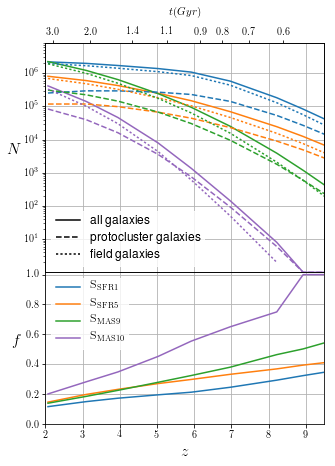

In [8]:
fig = plt.figure(figsize=(5, 7))

gs = gridspec.GridSpec(5, 1)

gs.update(hspace=0) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0:3,0])
ax2 = fig.add_subplot(gs[3:5,0])

z = [2.07, 3.10, 3.95, 5.03, 5.92, 6.97, 8.22, 8.93, 9.72]

# Plot 1
ax1.semilogy(z, [f['size'] for f in sfr_frac], color='C0')
ax1.semilogy(z, [f['size'] for f in sfr5_frac], color='C1')
ax1.semilogy(z, [f['size'] for f in mstar_frac], color='C2')
ax1.semilogy(z, [f['size'] for f in mstar10_frac], color='C4')

ax1.semilogy(z, [f['pcs'] for f in sfr_frac], linestyle='dashed', color='C0')
ax1.semilogy(z, [f['pcs'] for f in sfr5_frac], linestyle='dashed', color='C1')
ax1.semilogy(z, [f['pcs'] for f in mstar_frac], linestyle='dashed', color='C2')
ax1.semilogy(z, [f['pcs'] for f in mstar10_frac], linestyle='dashed', color='C4')

ax1.semilogy(z, [f['field'] for f in sfr_frac], linestyle='dotted', color='C0')
ax1.semilogy(z, [f['field'] for f in sfr5_frac], linestyle='dotted', color='C1')
ax1.semilogy(z, [f['field'] for f in mstar_frac], linestyle='dotted', color='C2')
ax1.semilogy(z, [f['field'] for f in mstar10_frac], linestyle='dotted', color='C4')

ax1.set_xticklabels([])
ax1.set_ylim(1.05, 8e6)

# Plot 2
ax2.plot(z, [f['frac'] for f in sfr_frac], color='C0')
ax2.plot(z, [f['frac'] for f in sfr5_frac], color='C1')
ax2.plot(z, [f['frac'] for f in mstar_frac], color='C2')
ax2.plot(z, [f['frac'] for f in mstar10_frac], color='C4')

# labels
ax2.set_ylabel('$f$', rotation=0, size=16, labelpad=10)
ax1.set_ylabel('$N$', rotation=0, size=16, labelpad=11)
ax2.set_xlabel('$z$', size=16)


# legends
line1 = plt.Line2D((0,1),(0,0), color='black', linestyle='solid')
line2 = plt.Line2D((0,1),(0,0), color='black', linestyle='dashed')
line3 = plt.Line2D((0,1),(0,0), color='black', linestyle='dotted')

legend = ax1.legend(handles=[line1, line2, line3], labels=['all galaxies','protocluster galaxies','field galaxies'], 
                    loc=3, prop={'size':12})

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

line_sfr = plt.Line2D((0,1),(0,0), color='C0', linestyle='solid')
line_sfr5 = plt.Line2D((0,1),(0,0), color='C1', linestyle='solid')
line_mstar = plt.Line2D((0,1),(0,0), color='C2', linestyle='solid')
line_mstar10 = plt.Line2D((0,1),(0,0), color='C4', linestyle='solid')

legend = ax2.legend(handles=[line_sfr, line_sfr5, line_mstar, line_mstar10],
           labels=['$\mathrm{S}_{\mathrm{SFR1}}$', '$\mathrm{S}_{\mathrm{SFR5}}$',
                   '$\mathrm{S}_{\mathrm{MAS9}}$','$\mathrm{S}_{\mathrm{MAS10}}$'], 
                    loc=2, prop={'size':12})

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

axt = ax1.twiny() # twin x axis
axt.set_xticks(ageticks)
axt.set_xticklabels(["$%.1f$"%age for age in ages.value]);
axt.set_xlabel('$t (Gyr)$', size=11, labelpad=12)
axt.set_xlim(2,9.5)

ax2.set_ylim(0, 1.02)

for ax in [ax1, ax2]:
    ax.grid()
    ax.set_xlim(2,9.5)
    

# plt.savefig(out_directory+'pc_fractions.png', bbox_inches='tight', dpi=300)